# Run Model Explanation with SageMaker Clarify (Post-Training)

## Using SageMake Processing Jobs

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [2]:
%store -r training_job_name

In [3]:
try:
    training_job_name
    print('[OK]')
except NameError:
    print('+++++++++++++++++++++++++++++++')
    print('[ERROR] Please run the notebooks in the previous TRAIN section before you continue.')
    print('+++++++++++++++++++++++++++++++')

[OK]


In [4]:
print(training_job_name)

tensorflow-training-2021-01-28-01-19-50-987


In [5]:
# # updated inference.py with correct json parsing
# training_job_name='tensorflow-training-2021-01-27-23-37-00-180'

# Get Data

In [6]:
import pandas as pd

data = pd.read_json('./data-clarify/amazon_reviews_us_giftcards_software_videogames_balanced.jsonl', lines=True)
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,43630866,R3K6VPY2NE6262,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,works great,"i like the gift cards, if you need something q...",2013-10-27
1,US,52721479,R2VSBSVBPO5N94,B00CT77B7M,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Five Stars,"Beautiful card, the person receiving this also...",2015-05-25
2,US,25341626,RC62YY8GHYO67,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Five Stars,The Amazon Gift Card is the Perfect Gift somet...,2015-05-15
3,US,42898788,R35VSTQDN6CPDG,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Five Stars,ilove,2014-10-29
4,US,2943280,R3RA8FDVJDSKB5,B00H5BMH44,81025991,Amazon eGift Card - Hoops and Yoyo Cake Face (...,Gift Card,5,0,0,N,Y,Five Stars,I love Hoops and Yoyo. It is fun.,2014-12-10


In [7]:
data.shape

(81040, 15)

### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered _sensitive_.  
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

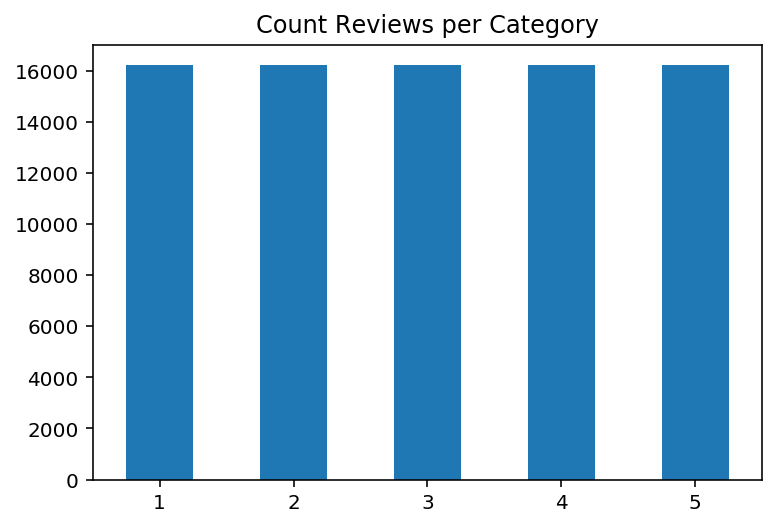

In [9]:
data['star_rating'].value_counts().sort_values().plot(kind='bar', title='Count Reviews per Category', rot=0)

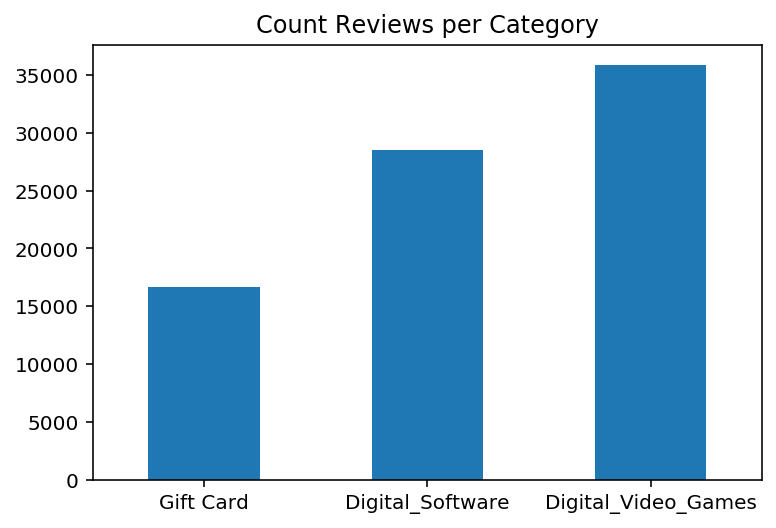

In [10]:
data['product_category'].value_counts().sort_values().plot(kind='bar', title='Count Reviews per Category', rot=0)

# Create Model

In [11]:
import sagemaker

inference_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type='ml.m5.4xlarge',
    image_scope="inference"
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu


In [12]:
model_name = sess.create_model_from_job(
    training_job_name=training_job_name,
    image_uri=inference_image_uri
)

Using already existing model: tensorflow-training-2021-01-28-01-19-50-987


In [13]:
print(model_name)

tensorflow-training-2021-01-28-01-19-50-987


# Explaining Predictions with Amazon SageMaker Clarify

There are expanding business needs and legislative regulations that require explainations of _why_ a model mades the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

In [14]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c5.2xlarge',
                                                      sagemaker_session=sess)

# patch image in Thundera devo account. It is the initial launch image plus the JSONLines bug fix
clarify_processor.image_uri = "678264136642.dkr.ecr.us-east-1.amazonaws.com/sagemaker-clarify-processing:1.0_jsonlines_patch"

## Writing DataConfig and ModelConfig
A `DataConfig` object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

Similarly, the `ModelConfig` object communicates information about your trained model and `ModelPredictedLabelConfig` provides information on the format of your predictions.  

**Note**: To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. `ModelConfig` specifies your preferred instance type and instance count used to run your model on during Clarify's processing.

In [15]:
post_train_dataset = data[['star_rating', 'product_category', 'review_body']]
post_train_dataset.shape

In [17]:
post_train_dataset.head()

,star_rating,product_category,review_body
0,5,Gift Card,"i like the gift cards, if you need something q..."
1,5,Gift Card,"Beautiful card, the person receiving this also..."
2,5,Gift Card,The Amazon Gift Card is the Perfect Gift somet...
3,5,Gift Card,ilove
4,5,Gift Card,I love Hoops and Yoyo. It is fun.


# Select n samples across each category

## _Note: We need to have >1 product_categories (facet values) in our training data._

In [18]:
# TODO:  CHANGE THIS BACK TO .sample(10)
# TODO:  REMOVE THE INDEX (0, 1, etc)
# TODO:  REMOVE THE DUPLICATE product_category IN THIS GROUPBY
# TODO:  WHY ARE WE USING groupby?
bias_data = post_train_dataset.groupby('product_category', group_keys=False).apply(lambda s: s.sample(5))
bias_data.reset_index(drop=True, inplace=True)
bias_data.shape

(15, 3)

In [19]:
bias_data

,star_rating,product_category,review_body
0,1,Digital_Software,"Don't download this, its junk and messes up th..."
1,2,Digital_Software,"Sorry, it can't record a lot of my favorite st..."
2,2,Digital_Software,"The product itself is good. Having said that, ..."
3,1,Digital_Software,Three years now they've done nothing to fix th...
4,4,Digital_Software,iBank 5+ was unnecessarily renamed Banktivity ...
5,1,Digital_Video_Games,Hate it! Piece of trash
6,5,Digital_Video_Games,Amazing! I bought it and in seconds I received...
7,1,Digital_Video_Games,This was an absolutely terrible game. It only...
8,4,Digital_Video_Games,"In particular, games 3 and 4 were the main rea..."
9,3,Digital_Video_Games,It's a great game for the cost. Runs well on ...


# Convert To Categorical dtype

## _Note: Otherwise Clarify converts (int) and (str) to continuous threshold values instead of categorial values._

In [20]:
bias_data['product_category'] = bias_data['product_category'].astype('category')

In [21]:
bias_data['product_category'].dtype

CategoricalDtype(categories=['Digital_Software', 'Digital_Video_Games', 'Gift Card'], ordered=False)

In [22]:
bias_data['star_rating'] = bias_data['star_rating'].astype('category')

In [23]:
bias_data['star_rating'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=False)

In [24]:
bias_data

,star_rating,product_category,review_body
0,1,Digital_Software,"Don't download this, its junk and messes up th..."
1,2,Digital_Software,"Sorry, it can't record a lot of my favorite st..."
2,2,Digital_Software,"The product itself is good. Having said that, ..."
3,1,Digital_Software,Three years now they've done nothing to fix th...
4,4,Digital_Software,iBank 5+ was unnecessarily renamed Banktivity ...
5,1,Digital_Video_Games,Hate it! Piece of trash
6,5,Digital_Video_Games,Amazing! I bought it and in seconds I received...
7,1,Digital_Video_Games,This was an absolutely terrible game. It only...
8,4,Digital_Video_Games,"In particular, games 3 and 4 were the main rea..."
9,3,Digital_Video_Games,It's a great game for the cost. Runs well on ...


# Create Explainability Data Set Without Label Column

In [27]:
explainability_data = bias_data.drop(['star_rating'], axis=1)
explainability_data.shape

(15, 2)

In [28]:
explainability_data.head()

,product_category,review_body
0,Digital_Software,"Don't download this, its junk and messes up th..."
1,Digital_Software,"Sorry, it can't record a lot of my favorite st..."
2,Digital_Software,"The product itself is good. Having said that, ..."
3,Digital_Software,Three years now they've done nothing to fix th...
4,Digital_Software,iBank 5+ was unnecessarily renamed Banktivity ...


# Convert to `jsonlines` Format and Upload To S3

In [29]:
path = './data-clarify/test_explainability.jsonl'

In [ ]:
# path = './data-clarify/post_train_data_explainability.jsonl'
# data.to_json(path, orient="records", lines=True)

In [30]:
post_train_dataset_explainability_s3_uri = sess.upload_data(bucket=bucket, key_prefix=training_job_name, path=path)
post_train_dataset_explainability_s3_uri

's3://sagemaker-us-east-1-835319576252/tensorflow-training-2021-01-28-01-19-50-987/test_explainability.jsonl'

# Configure Clarify

In [31]:
from sagemaker import clarify

model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.m5.4xlarge',
                                   instance_count=1,
                                   content_type='application/jsonlines',
                                   accept_type='application/jsonlines',
                                   content_template='{"features":$features}')

In [32]:
explainability_output_path = 's3://{}/clarify-explainability'.format(bucket)

explainability_data_config = clarify.DataConfig(s3_data_input_path=post_train_dataset_explainability_s3_uri,
                                s3_output_path=explainability_output_path,
#                                label='star_rating',
                                headers=['review_body', 'product_category'],
                                features='features',
                                dataset_type='application/jsonlines')

In [33]:
shap_config = clarify.SHAPConfig(baseline=post_train_dataset_explainability_s3_uri, # [explainability_data.iloc[0].values.tolist()],
                                 num_samples=5,
                                 agg_method='mean_abs')

## _Note: `label` is set to the JSON key for the model prediction results_

In [ ]:
#predictions_config = clarify.ModelPredictedLabelConfig(label='predicted_label')

## Run Clarify

In [34]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c5.2xlarge',
                                                      sagemaker_session=sess)

In [35]:
run_explainability_response = clarify_processor.run_explainability(model_config=model_config,
                                     model_scores='predicted_label',
                                     data_config=explainability_data_config,                                     
                                     explainability_config=shap_config,
                                     wait=False)


Job Name:  Clarify-Explainability-2021-01-28-02-24-22-510
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/tensorflow-training-2021-01-28-01-19-50-987/test_explainability.jsonl', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/Clarify-Explainability-2021-01-28-02-24-22-510/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3Upload

UnexpectedStatusException: Error for Processing job Clarify-Explainability-2021-01-28-02-24-22-510: Failed. Reason: ClientError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "{"error": "Expecting value: line 1 column 14 (char 13)"}". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-clarify-endpoint-1611800897-617e in account 835319576252 for more information.


In [ ]:
run_explainability_job_name = run_explainability_response['JobName']
print(run_explainability_job_name)

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(region, run_explainability_job_name)))


In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(region, run_explainability_job_name)))


In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(bucket, run_explainability_job_name, region)))


In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_explainability_job_name,
                                                                            sagemaker_session=sess)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
running_processor.wait(logs=False)

#### Viewing the Explainability Report
As with the bias report, you can view the explainability report in Studio under the experiments tab


<img src="img/explainability_detail.gif">

The Model Insights tab contains direct links to the report and model insights.

If you're not a Studio user yet, as with the Bias Report, you can access this report at the following S3 bucket.

# Download Report From S3

In [ ]:
!aws s3 ls $explainability_output_path/

In [ ]:
!aws s3 cp --recursive $explainability_output_path ./explainability_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./explainability_report/report.html">Explainability Report</a></b>'))


# Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}